In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

set_rc()

In [2]:
res = pickle.load(open('data/meta_representation_results', 'rb'))
ares = pickle.load(open('data/meta_rnn_gradients', 'rb'))

In [3]:
def print_model(idx):
    mstr = ''
    if idx[0] == 0:
        mstr += 'No Rew Info, '
    else:
        mstr += 'Rew Given, '
        
    mstr += f'Pop: {pop_labels[idx[1]]}, '
    mstr += f'p: {p_labels[idx[2]]}, '
    mstr += f'Trial {idx[3] + 1}'
    print(mstr)


In [7]:
idx = select_random_model()
idx = idx[:4]
rnn_hxs = ares['all_rnn_hxs'][idx]

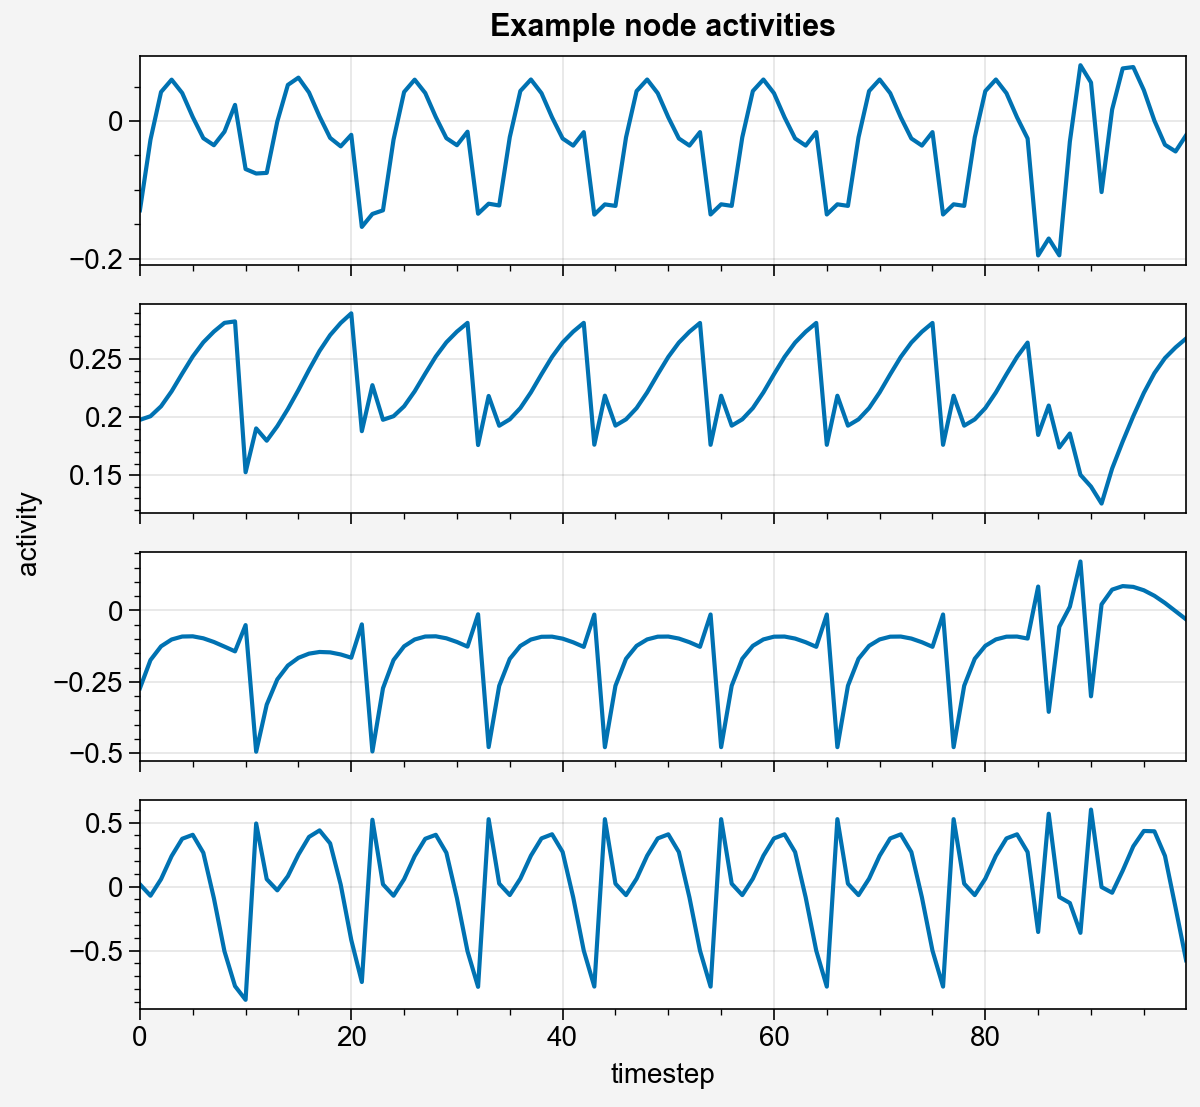

In [15]:
fig, ax = pplt.subplots(nrows=4, refaspect=5, figwidth=6)
for i in range(4):
    ax[i].plot(rnn_hxs[1600:1700, i*5])

ax.format(xlabel='timestep', ylabel='activity', suptitle='Example node activities')


In [204]:
idx = (1, 2, 2, 0)
idx = select_chks([idx])[0]
model, obs_rms = metabart_model_load(idx)
r = evalu(model, obs_rms, give_rew=True)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


Rew Given, Pop: -0.1, p: 1.5, Trial 1
0 7
1 7
2 5
3 7
4 2
5 11
6 14
7 17
8 15
9 7
10 5
11 0
12 0
13 0
14 0
15 0
16 0


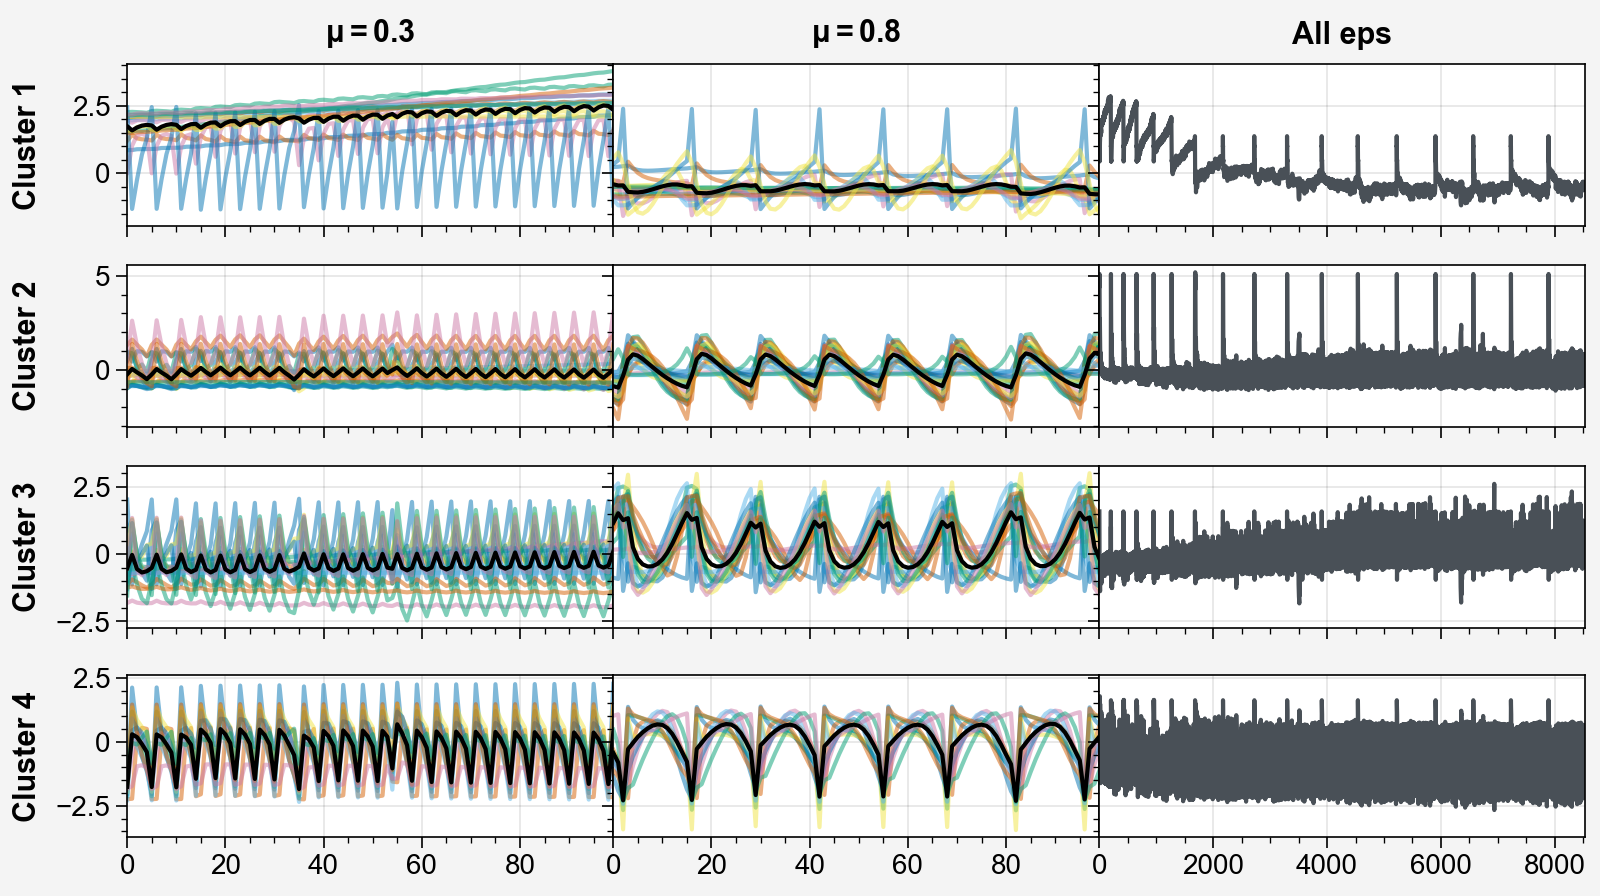

In [17]:
# idx, model, obs_rms, r = select_random_model(1, load_models=True)

idx = (1, 2, 2, 0)
idx = select_chks([idx])[0]
model, obs_rms = metabart_model_load(idx)
r = evalu(model, obs_rms, give_rew=True)

k, cluster_activ, labels, kmeans, orientation = kmeans_oriented_activations(r, layer='rnn_hxs')
give = idx[0] == 1
visualize_cluster_activations_combined(r, labels, cluster_activ, orientation=orientation,
                                       include_components=True)

print_model(idx)
for ep in range(17):
    popped = r['data']['popped'][ep]
    print(ep, np.sum(popped))

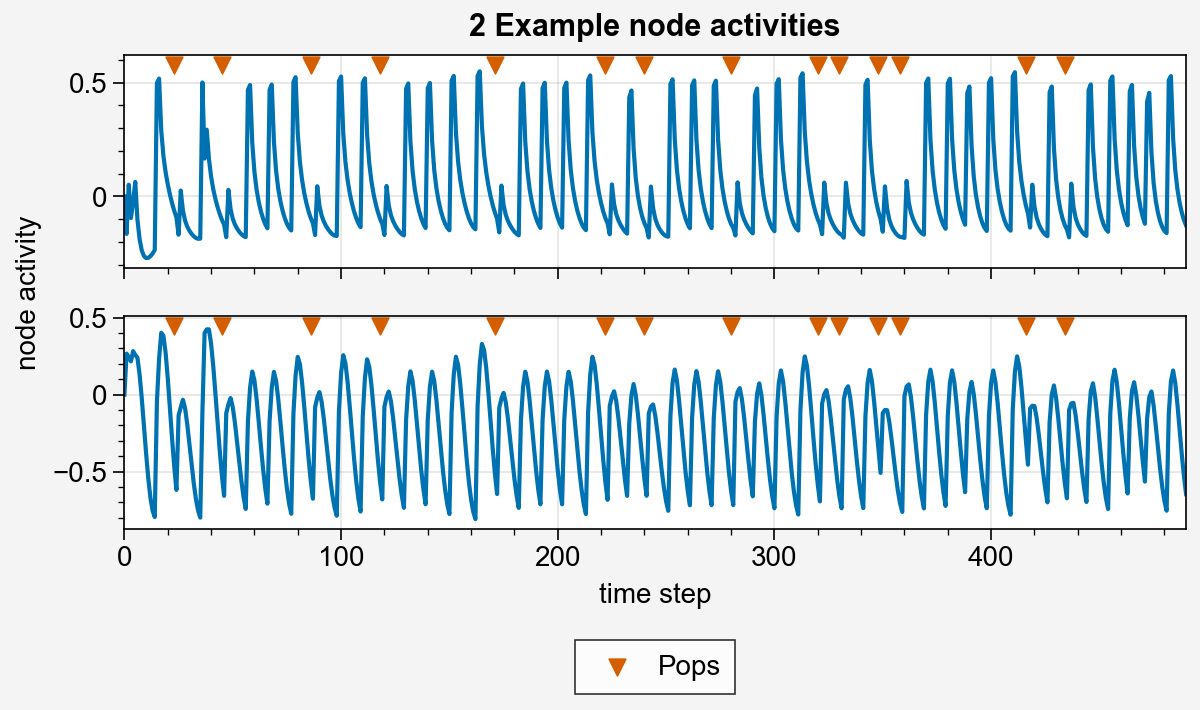

In [ ]:
ep = 6
idxs = [34, 37]

rnn_hxs = r['rnn_hxs'][ep]
starts, ends = starts_and_ends(r)
s, e = starts[ep], ends[ep]
popped = r['data']['popped'][ep]
popped_steps = np.array(r['data']['balloon_step'][ep])[popped]

fig, ax = pplt.subplots(refaspect=5, figwidth=6, nrows=2)
i = 37
for i, idx in enumerate(idxs):
    lines = []
    a = rnn_hxs[:, idx]
    max_a = np.max(a)
    ax[i].plot(a)
    lines.append(ax[i].scatter(popped_steps, [max_a*1.05]*len(popped_steps), marker='v', label='Pops'))

fig.legend(lines, loc='b')
ax.format(xlabel='time step', ylabel='node activity', suptitle='Example node activities')

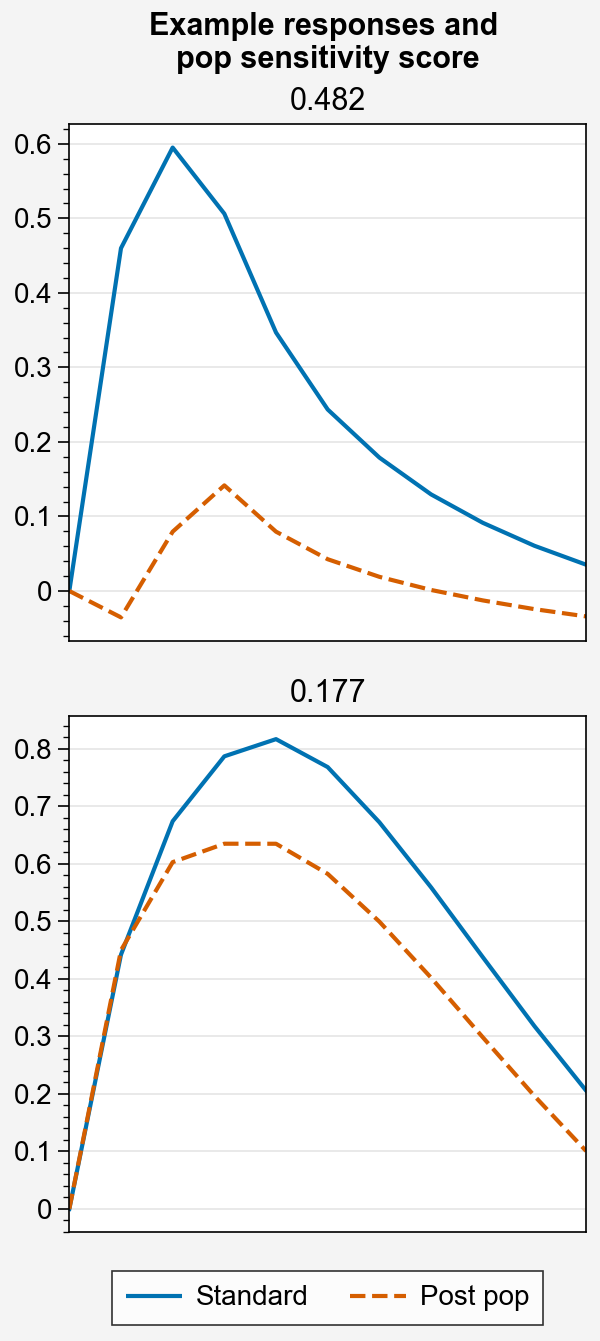

In [294]:
ep = 6
idxs = [34, 37]
fig, ax = pplt.subplots(nrows=2, figwidth=3)

for i, idx in enumerate(idxs):
    a = rnn_hxs[:, idx]
    standard_responses, pop_responses = segment_responses(a, s, e, popped_steps)
    lines = plot_stretched_responses(standard_responses, pop_responses, ax=ax[i])
    
ax.format(xlocator=[], suptitle='Example responses and \npop sensitivity score')
fig.legend(lines, loc='b')

In [277]:
from scipy.interpolate import interp1d

def segment_responses(activ, starts, ends, popped_steps, normalize_by_start=True):
    """Segment time series based on stimulus periods and mark modified responses."""
    standard_responses = []
    pop_responses = []
    
    prev_popped = False
    for start, end in zip(starts, ends):
        response = activ[start:end]
        if normalize_by_start:
            response = response - response[0]
        if prev_popped:
            pop_responses.append(response)
        else:
            standard_responses.append(response)
        if end in popped_steps:
            prev_popped = True
        else:
            prev_popped = False

    return standard_responses, pop_responses


def stretch_responses(responses, target_length):
    """Stretch each response to a uniform length using interpolation."""
    stretched_responses = []
    for response in responses:
        original_length = len(response)
        if original_length < 2:
            continue
        x_original = np.linspace(0, 1, original_length)
        x_target = np.linspace(0, 1, target_length)
        interpolator = interp1d(x_original, response, kind='linear', fill_value="extrapolate")
        stretched_responses.append(interpolator(x_target))
    return np.array(stretched_responses)


def plot_stretched_responses(standard_responses, pop_responses, ax=None):
    """Plot average responses for standard and modified stimuli after stretching."""
    # Determine the maximum length to align all responses
    if ax is None:
        fig, ax = pplt.subplots()

    lines = []
    
    max_length = max(map(len, standard_responses + pop_responses))
    resp1 = stretch_responses(standard_responses, max_length)
    resp2 = stretch_responses(pop_responses, max_length)
    mean_resp1 = np.mean(resp1, axis=0)
    mean_resp2 = np.mean(resp2, axis=0)

    lines.append(ax.plot(mean_resp1, label='Standard'))
    lines.append(ax.plot(mean_resp2, linestyle='--', label='Post pop'))
    
    mad = np.mean(np.abs(mean_resp1 - mean_resp2))
    norm_factor = np.mean(np.abs(mean_resp1))
    # nmad = mad / norm_factor
    # ax.format(title=f'{mad:.3f}')
    nmad = mad / (mean_resp1.std() + mean_resp2.std() + 0.2)
    ax.format(title=f'{nmad:.3f}')
    
    return lines
    
def prep_response_info(res, ep=0):
    starts, ends = starts_and_ends(res)
    s, e = starts[ep], ends[ep]
    popped = res['data']['popped'][ep]
    popped_steps = np.array(res['data']['balloon_step'][ep])[popped]
    return s, e, popped_steps

def compute_pop_sensitivity_scores_ep(res, ep=0, layer='rnn_hxs', normalize=True):
    '''
    Compute how pop sensitive each node in a layer is
    normalize: will use a specific normalization of standard deviation + 0.5 to account
        for some activities that just don't change much and prevent them from dominating
    '''
    if layer == 'rnn_hxs':
        activ = res['rnn_hxs'][ep]
    else:
        activ = res['activations'][layer][ep]

    starts, ends = starts_and_ends(res)
    s, e = starts[ep], ends[ep]
    popped = res['data']['popped'][ep]
    popped_steps = np.array(res['data']['balloon_step'][ep])[popped]

    pop_sensitivity_scores = []
    for i in range(64):
        a = activ[:, i]
        standard_responses, pop_responses = segment_responses(a, s, e, popped_steps)
        max_length = max(map(len, standard_responses + pop_responses))
        resp1 = stretch_responses(standard_responses, max_length)
        resp2 = stretch_responses(pop_responses, max_length)
        mean_resp1 = np.mean(resp1, axis=0)
        mean_resp2 = np.mean(resp2, axis=0)
        mad = np.mean(np.abs(mean_resp1 - mean_resp2))
        if normalize:
            mad = mad / (mean_resp1.std() + mean_resp2.std() + 0.2)
        pop_sensitivity_scores.append(mad)
        
    return np.array(pop_sensitivity_scores)


In [213]:

standard_responses, pop_responses = segment_responses(a, s, e, popped_steps)
max_length = max(map(len, standard_responses + pop_responses))
resp1 = stretch_responses(standard_responses, max_length)
resp2 = stretch_responses(pop_responses, max_length)
mean_resp1 = np.mean(resp1, axis=0)
mean_resp2 = np.mean(resp2, axis=0)

mad = np.mean(np.abs(mean_resp1 - mean_resp2))
norm_factor = np.mean(np.abs(mean_resp1))
nmad = mad / norm_factor

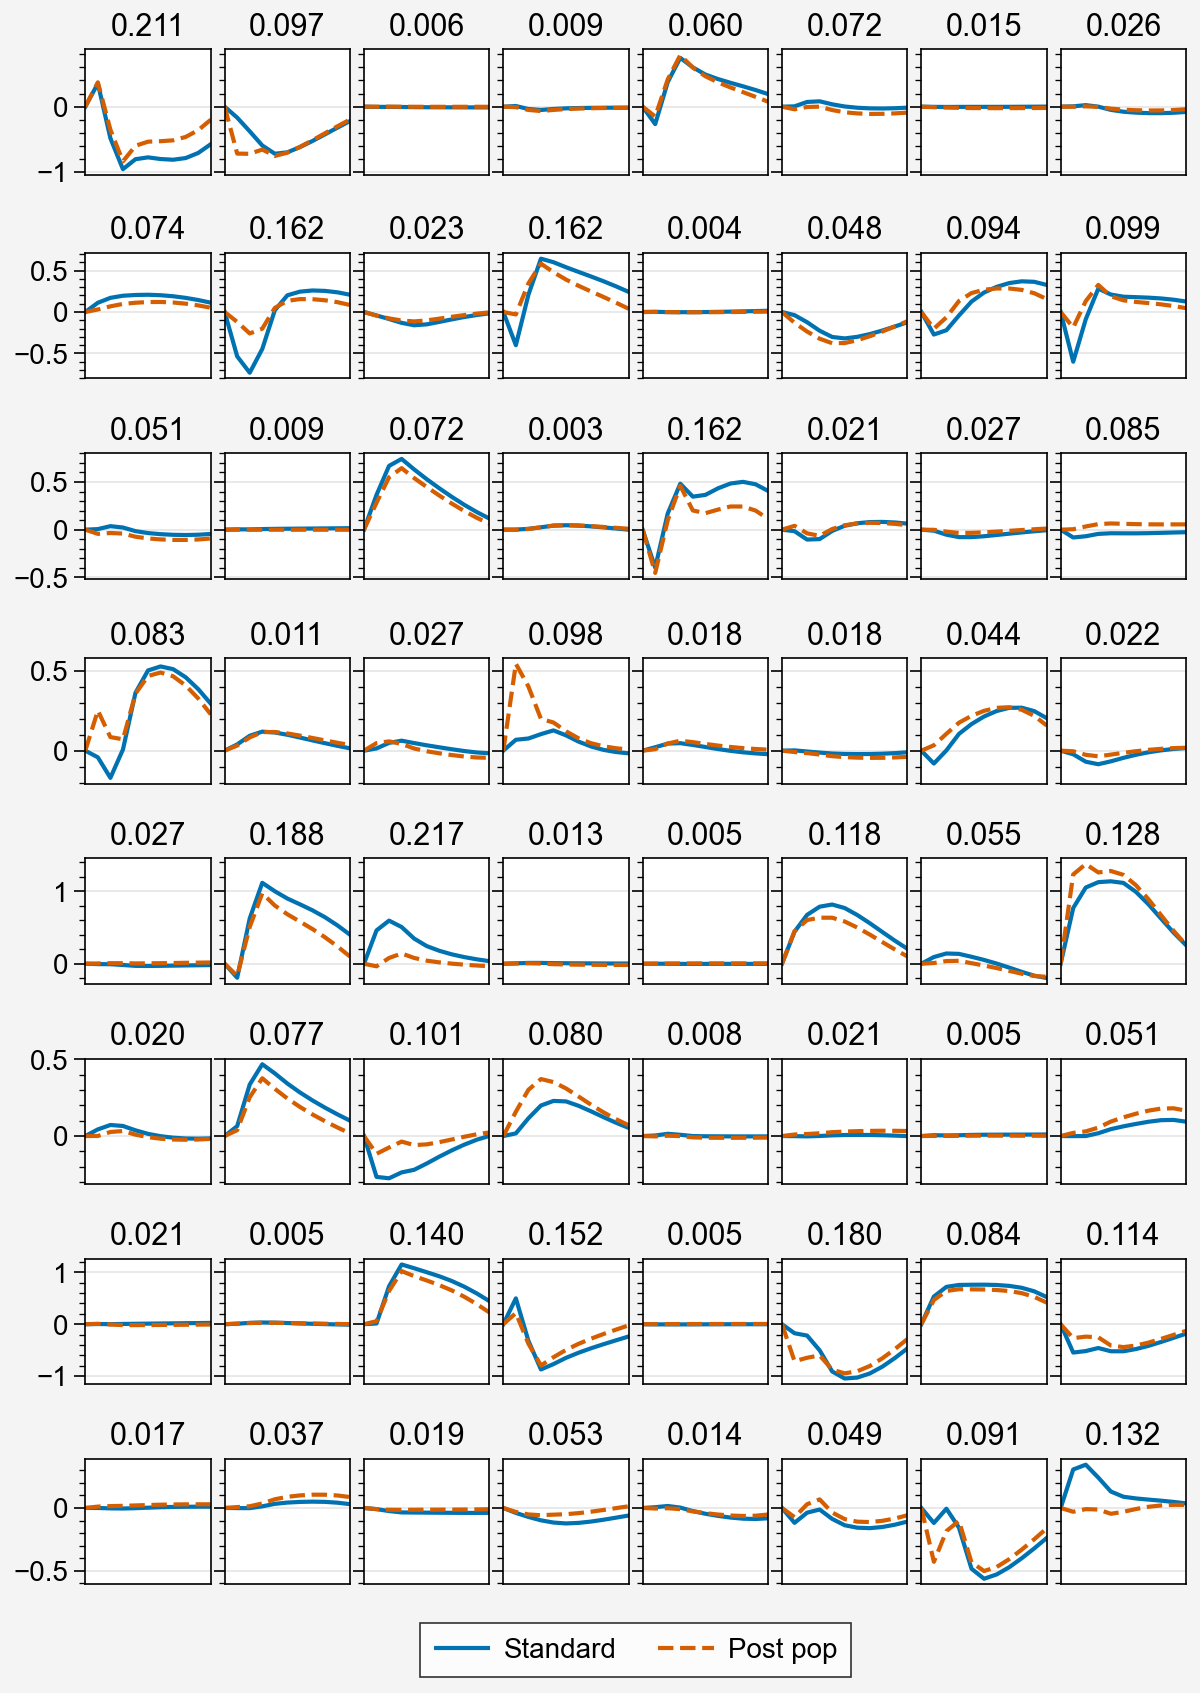

In [211]:
fig, ax = pplt.subplots(nrows=8, ncols=8, figwidth=6, wspace=0.5)
for i in range(64):
    a = rnn_hxs[:, i]
    standard_responses, pop_responses = segment_responses(a, s, e, popped_steps)
    lines = plot_stretched_responses(standard_responses, pop_responses, ax=ax[i])
    
ax.format(xlocator=[])
fig.legend(lines, loc='b')

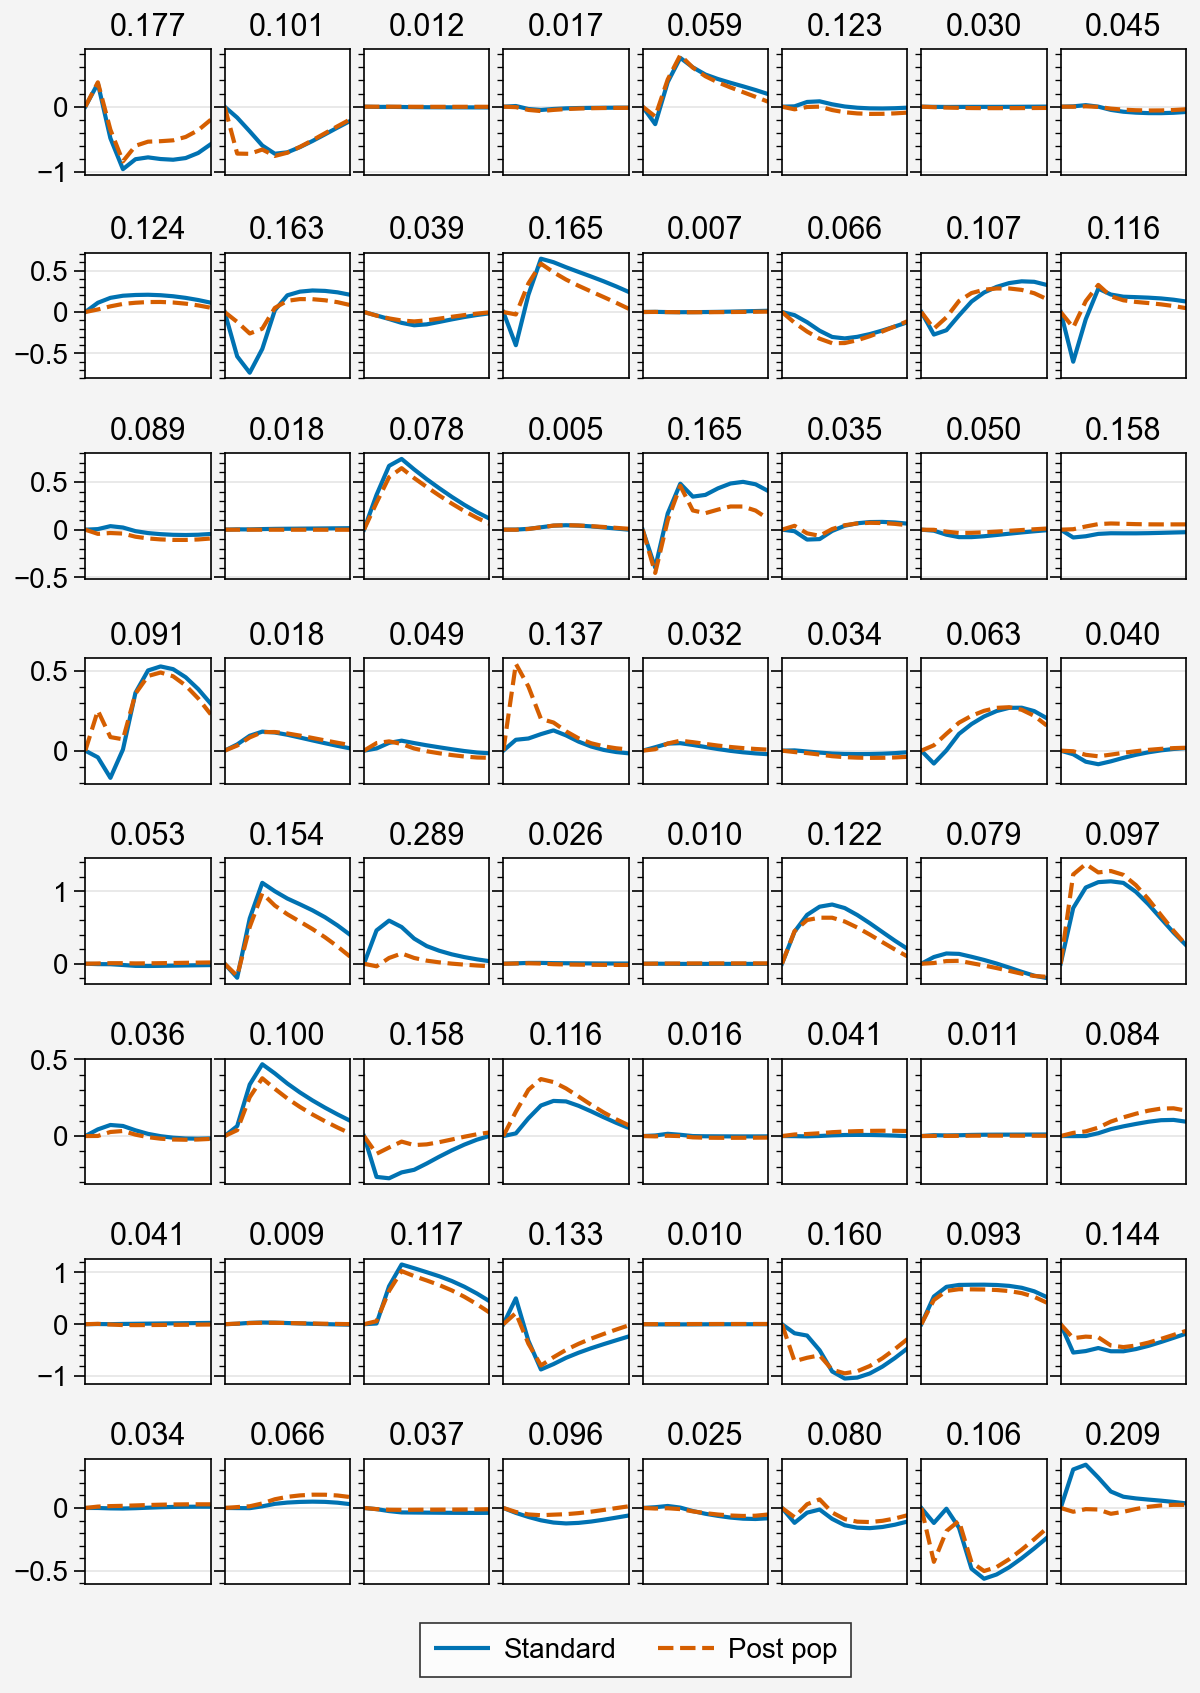

In [226]:
fig, ax = pplt.subplots(nrows=8, ncols=8, figwidth=6, wspace=0.5)
for i in range(64):
    a = rnn_hxs[:, i]
    standard_responses, pop_responses = segment_responses(a, s, e, popped_steps)
    lines = plot_stretched_responses(standard_responses, pop_responses, ax=ax[i])
    
ax.format(xlocator=[])
fig.legend(lines, loc='b')

# Use precollected forced_ares to collect pop sensitivity scores

In [140]:
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))

In [ ]:
all_pop_sensitivity_scores = {}
all_pop_sensitivity_counts = {}
all_idxs = list(forced_ares['all_rnn_hxs'].keys())

for idx in tqdm(all_idxs):
    give = idx[0] == 1
    if give:
        r = forced_ares['give_res'].copy()
    else:
        r = forced_ares['res'].copy()
    rnn_hxs = forced_ares['all_rnn_hxs'][idx]
    activ = split_by_ep(r, rnn_hxs)
    r['rnn_hxs'] = activ
    
    pop_sens = []    
    for ep in range(4):
        p = compute_pop_sensitivity_scores_ep(r, ep, normalize=False)
        pop_sens.append(p)
    pop_sens = np.mean(pop_sens, axis=0)
    
    all_pop_sensitivity_scores[idx] = pop_sens
    all_pop_sensitivity_counts[idx] = (pop_sens > 0.1).sum()

100%|██████████| 120/120 [02:49<00:00,  1.41s/it]


In [331]:
forced_ares['all_pop_sensitivity_scores'] = all_pop_sensitivity_scores
forced_ares['all_pop_sensitivity_counts'] = all_pop_sensitivity_counts

pickle.dump(forced_ares, open('data/meta_rnn_forced_gradients', 'wb'))


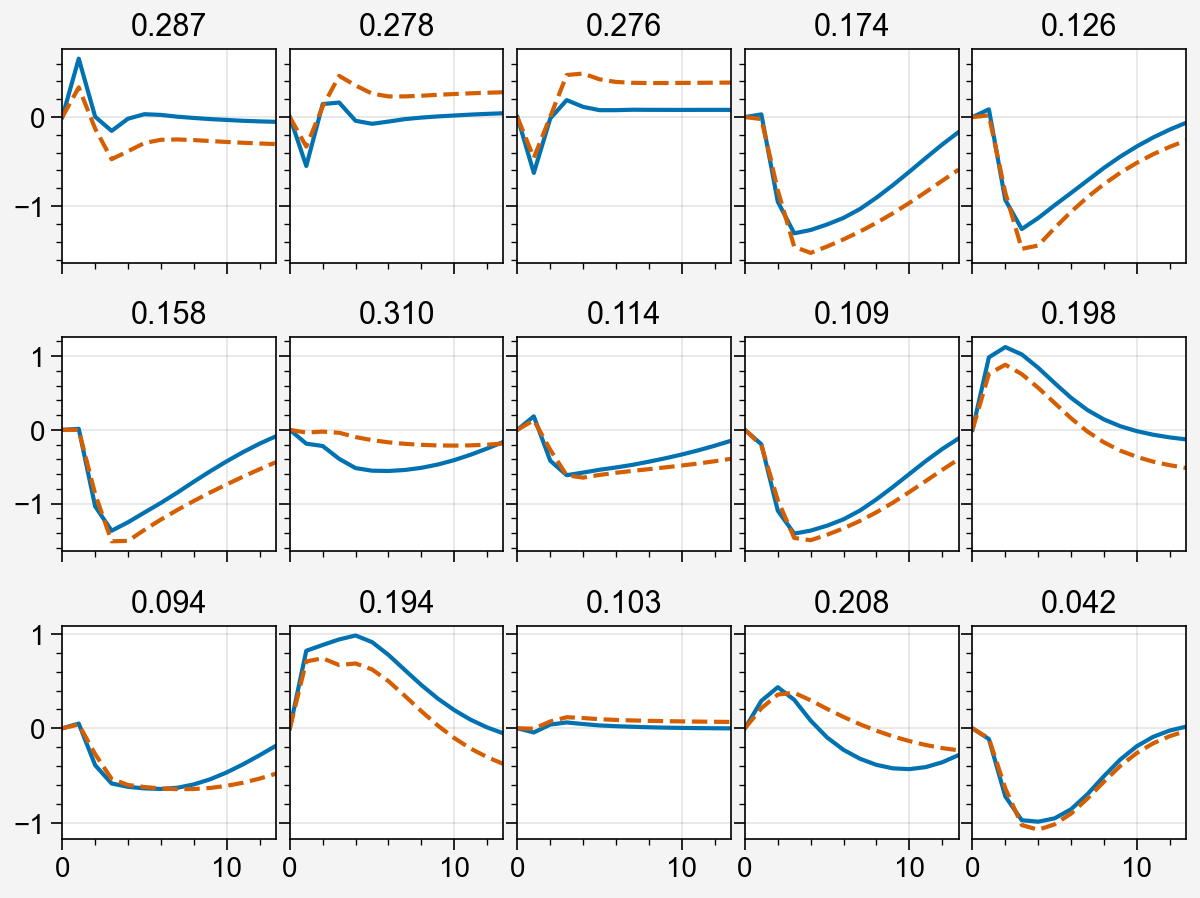

In [266]:
r = forced_ares['res']
ep = 3
s, e, p = prep_response_info(r, ep=ep)

fig, ax = pplt.subplots(nrows=3, ncols=5, figwidth=6, wspace=0.5)
idx = all_idxs[0]
rnn_hxs = split_by_ep(r, forced_ares['all_rnn_hxs'][idx])[ep]

pop_sens = all_pop_sensitivity_scores[idx]
node_idxs = np.argsort(-pop_sens)
for i in range(15):
    a = rnn_hxs[:, node_idxs[i]]
    standard_responses, pop_responses = segment_responses(a, s, e, p)
    lines = plot_stretched_responses(standard_responses, pop_responses, ax=ax[i])

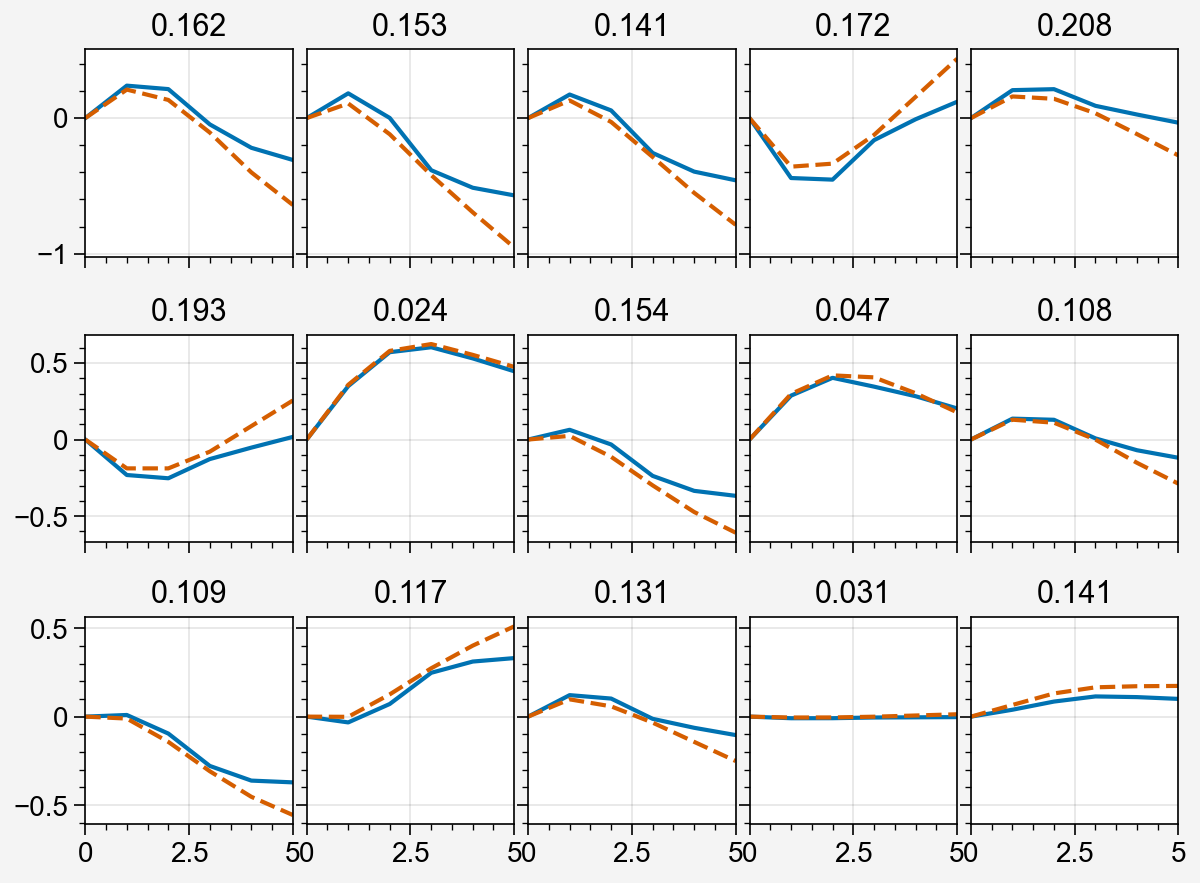

In [320]:
r = forced_ares['res']
ep = 0
s, e, p = prep_response_info(r, ep=ep)

fig, ax = pplt.subplots(nrows=3, ncols=5, figwidth=6, wspace=0.5)
idx = all_idxs[0]
rnn_hxs = split_by_ep(r, forced_ares['all_rnn_hxs'][idx])[ep]

pop_sens = all_pop_sensitivity_scores[idx]
node_idxs = np.argsort(-pop_sens)
for i in range(15):
    a = rnn_hxs[:, node_idxs[i]]
    standard_responses, pop_responses = segment_responses(a, s, e, p)
    lines = plot_stretched_responses(standard_responses, pop_responses, ax=ax[i])

# Summary pop sensitivity scores

In [23]:
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))

In [300]:
iterator_sizes = [len(i) for i in iterators[:4]]

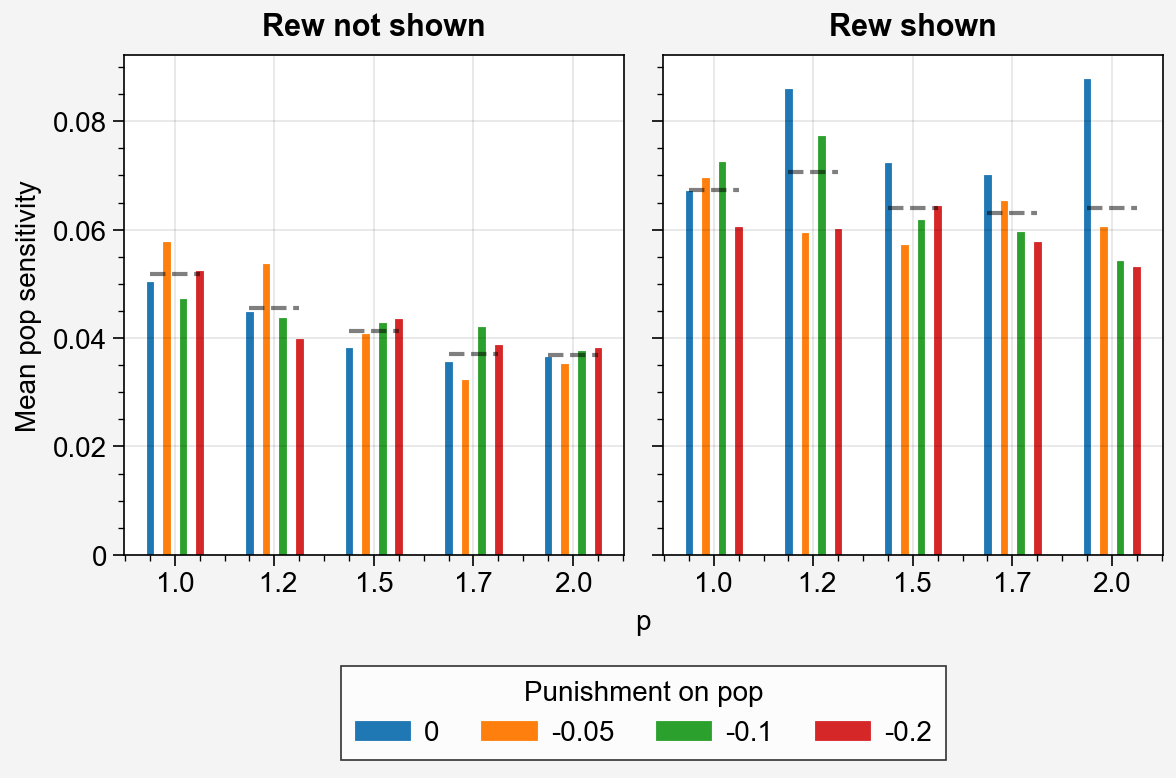

In [307]:
pop_sens = np.zeros(sizes + [64])
all_pop_sensitivity_scores = forced_ares['all_pop_sensitivity_scores']
for idx in all_idxs:
    pop_sens[idx] = all_pop_sensitivity_scores[idx]
pop_sens = pop_sens.mean(axis=4)

# reshape to array

fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    for j in range(len(p_labels)):
        bars = []
        ys = []
        for i in range(len(pop_labels)):
            x = j*6+i
            y = pop_sens[h, i, j, :].mean()
            bars.append(ax[h].bar(x, y, c=rgb_colors[i], label=pop_labels[i]))
            ys.append(y)
        y = np.mean(ys)
        ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
fig.legend(bars, loc='b', title=pop_axis, ncols=4)
ax.format(xlocator=np.arange(5)*6+1.5, xformatter=p_labels, xlabel=p_axis,
            ylabel='Mean pop sensitivity',
            toplabels=give_labels,
            title='')


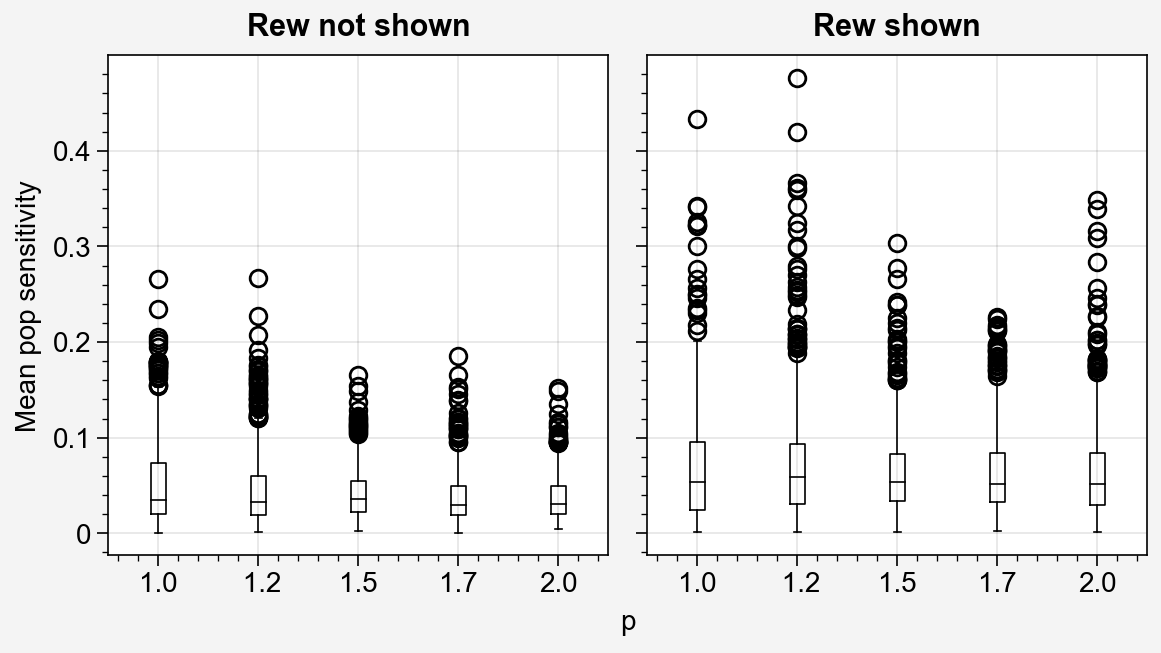

In [310]:
pop_sens = np.zeros(sizes + [64])
all_pop_sensitivity_scores = forced_ares['all_pop_sensitivity_scores']
for idx in all_idxs:
    pop_sens[idx] = all_pop_sensitivity_scores[idx]
pop_sens = pop_sens.mean(axis=4)

# reshape to array

fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    for j in range(5):
        y = pop_sens[h, :, j, :].reshape(-1)
        ax[h].boxplot(j, y)
        
# fig.legend(bars, loc='b', title=pop_axis, ncols=4)
ax.format(xlocator=np.arange(5), xformatter=p_labels, xlabel=p_axis,
            ylabel='Mean pop sensitivity',
            toplabels=give_labels,
            title='')


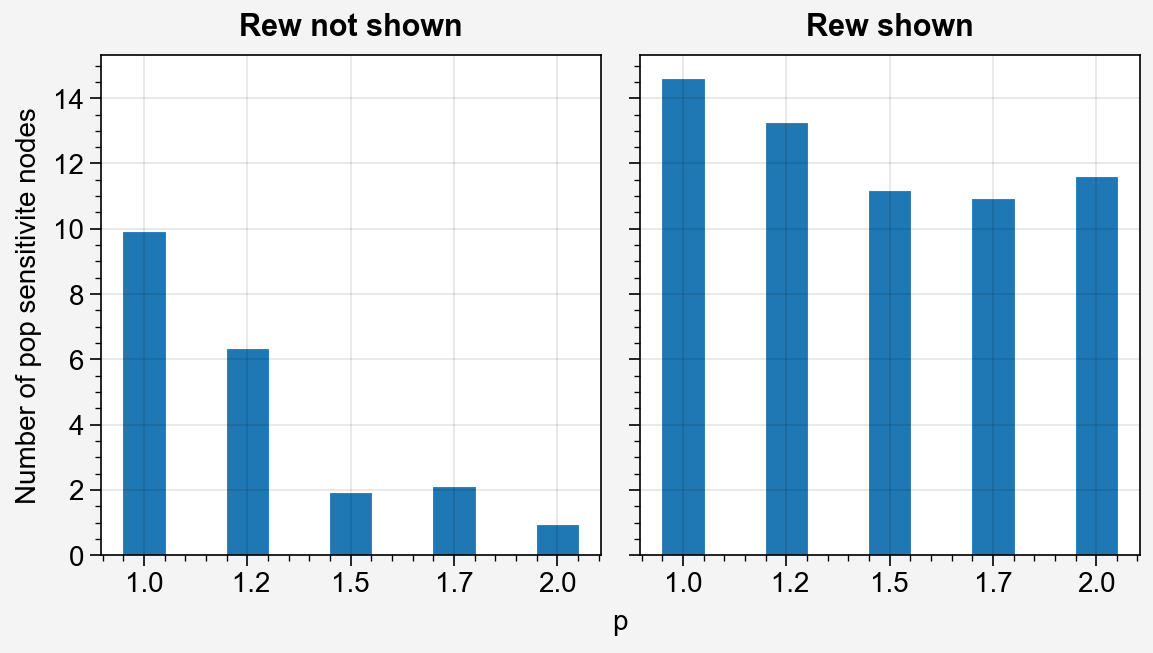

In [332]:
pop_counts = np.zeros(sizes)
all_pop_sensitivity_counts = forced_ares['all_pop_sensitivity_counts']
    
for idx in all_idxs:
    pop_counts[idx] = all_pop_sensitivity_counts[idx]

# reshape to array

fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    for j in range(5):
        y = pop_counts[h, :, j, :].mean()
        ax[h].bar(j, y, c=rgb_colors[0])
        
# fig.legend(bars, loc='b', title=pop_axis, ncols=4)
ax.format(xlocator=np.arange(5), xformatter=p_labels, xlabel=p_axis,
            ylabel='Number of pop sensitive nodes',
            toplabels=give_labels,
            title='')


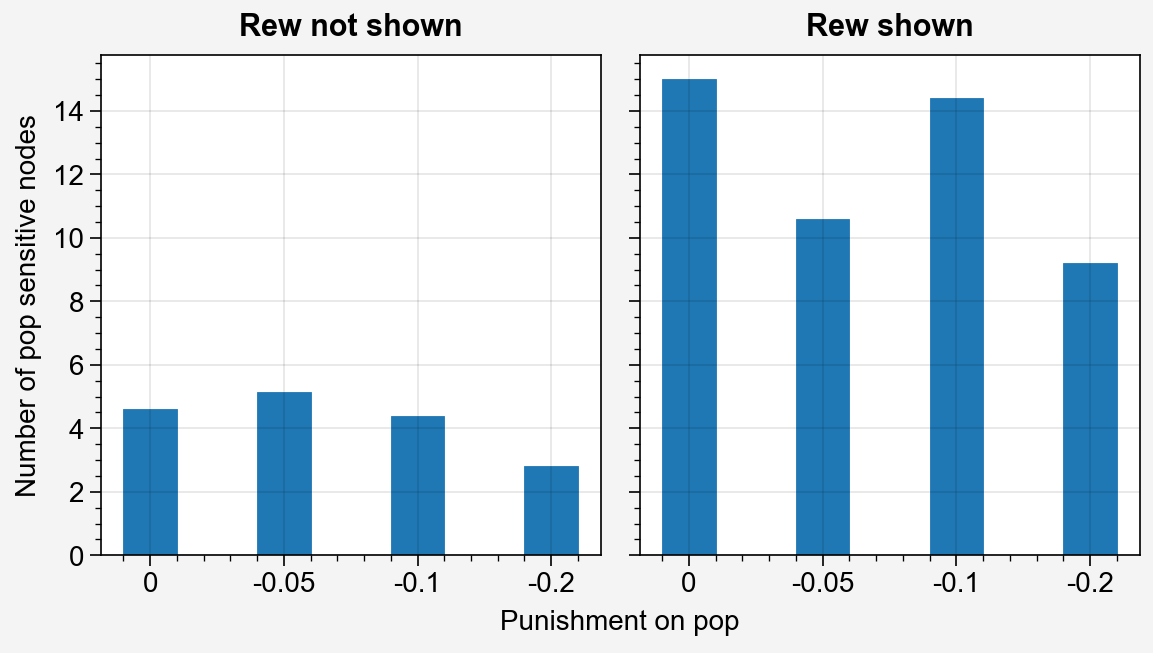

In [336]:
pop_counts = np.zeros(sizes)
all_pop_sensitivity_counts = forced_ares['all_pop_sensitivity_counts']
for idx in all_idxs:
    pop_counts[idx] = all_pop_sensitivity_counts[idx]

# reshape to array

fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    for i in range(4):
        y = pop_counts[h, i, :, :].mean()
        ax[h].bar(i, y, c=rgb_colors[0])
        
# fig.legend(bars, loc='b', title=pop_axis, ncols=4)
ax.format(xlocator=np.arange(4), xformatter=pop_labels, xlabel=pop_axis,
            ylabel='Number of pop sensitive nodes',
            toplabels=give_labels,
            title='')


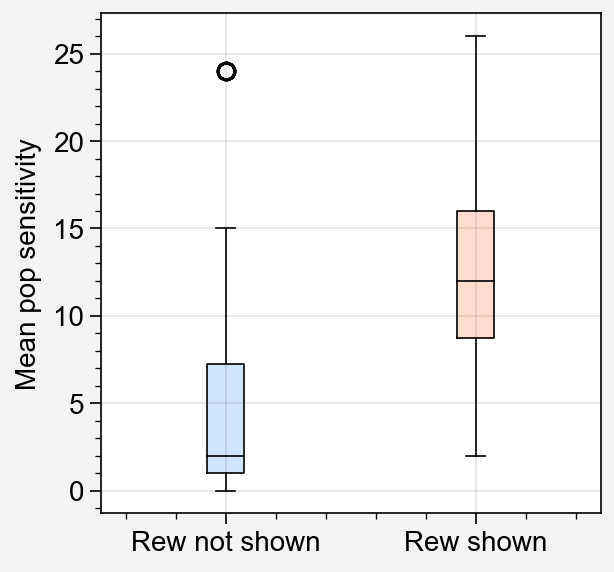

In [335]:
pop_counts = np.zeros(sizes)
all_pop_sensitivity_counts = forced_ares['all_pop_sensitivity_counts']
for idx in all_idxs:
    pop_counts[idx] = all_pop_sensitivity_counts[idx]

fig, ax = pplt.subplots()
for h in range(2):
    y = pop_counts[h, :, :, :].reshape(-1)
    ax.boxplot(h, y, cycle=rgb_colors[h])
        
# fig.legend(bars, loc='b', title=pop_axis, ncols=4)
ax.format(xlocator=np.arange(2), xformatter=give_labels,
            ylabel='Number of pop sensitive nodes',
            title='')
